In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


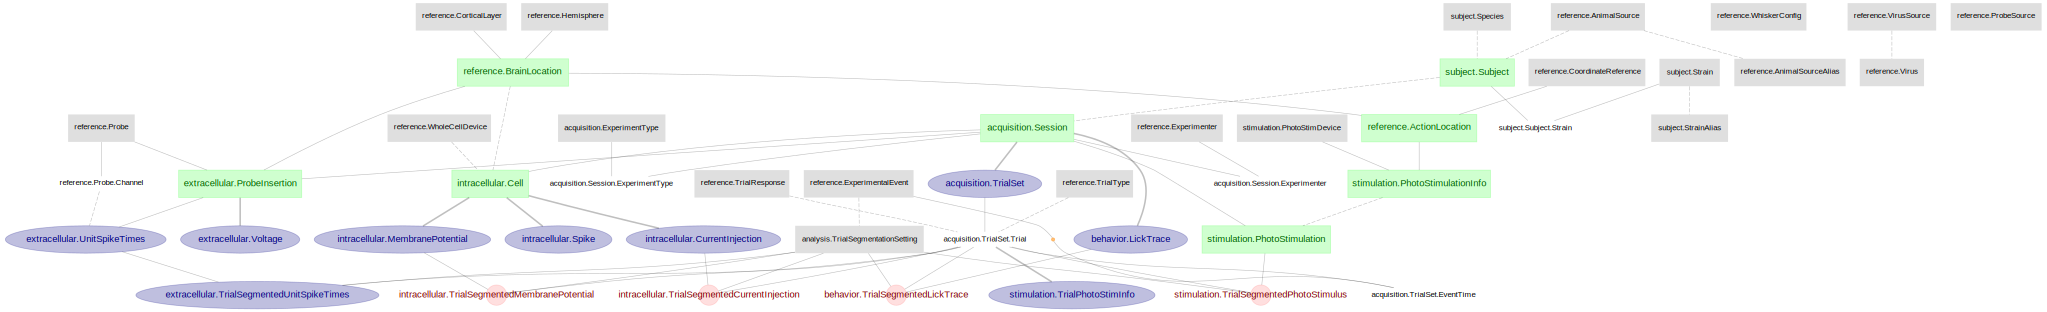

In [2]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproduce Figure 3a - whole-cell

In [7]:
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'delay_start', 'pre_stim_duration': 2, 'post_stim_duration': 3}).fetch1()

In [9]:
contra_trials = {'trial_type': 'lick right', 'trial_response': 'correct'}
ipsi_trials = {'trial_type': 'lick left', 'trial_response': 'correct'}

In [ ]:
cells = [96, 120, 149]

In [12]:
intracellular.Cell & {'cell_id': f'cell_{96}'}

session_id,cell_id a string identifying the cell in which this intracellular recording is concerning,cell_type,cell_depth (um),brain_region,brain_subregion,cortical_layer layer within cortex,hemisphere,device_name
05dd0016577e42f5861f087f894e856a,cell_167,Pyr,527.0,ALM,N/A,N/A,left,Multiclamp 700B
11489fe8ed9149a1bca516c0510985c7,cell_171,Pyr,500.0,ALM,N/A,N/A,left,Multiclamp 700B
120096373e854c069d95ad094cc3a61f,cell_119,Pyr,553.0,ALM,N/A,N/A,left,Multiclamp 700B
190cac5648f74d419fd0c7e283e13855,cell_185,Pyr,530.0,ALM,N/A,N/A,left,Multiclamp 700B
1b525850013d4901b49f536b361cab4c,cell_101,Pyr,679.0,ALM,N/A,N/A,left,Multiclamp 700B
1bc58430c8564d60b54024a362d78049,cell_177,Pyr,427.0,ALM,N/A,N/A,left,Multiclamp 700B
1daa26da7e424dee970b3d531d085a8e,cell_135,Pyr,571.0,ALM,N/A,N/A,left,Multiclamp 700B
